<a href="https://colab.research.google.com/github/sen-com/colaboratory/blob/main/GAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**編集中**
# 事例研究08回


| 回次   | 曜日     | 内容               |
| ------ | -------- | ------------------ |
| 第2回  | 10月20日(火)5限 | 上級生研究内容発表(1/2) |
| 第3回  | 10月27日(火)5限 | 上級生研究内容発表(2/2) |
| 第4回  | 11月3日(火) 5限 | Deepラーニングは怖くない(CIFIR10編)|
| 第5回  | 11月10日(火)5限 | Deepラーニングは怖くない(CIFIR10編)2|
| --    | 11月17日(火) | 試験期間               |
| 第6回  | 11月24日(火)5限 | Alexさんによる人の声を対象にしたWave-net                    |
| 第7回  | 12月1日(火) 5限 | 竹田さんによる楽器音を対象にしたWave-net                   |
| **第8回**  | **12月8日(火) 5限**| **佐藤+上松によるDCGANは怖くない**|
| 第9回  | 12月15日(火) 5限| 選択課題提示　   |
| 第10回 | 12月22日(火) 5限| 各自選んだテーマの発表        |
| 休み | *20日間の休み* |                    |
| 第11回 | 1月12日(火)  5限| 進捗報告①                  |
| 第12回 | 1月19日(火)  5限| 進捗報告②      |

## 今後の流れ

第9回では先輩方がいろいろ動きそうなプログラムを調べてくれます\
それを皆さんが自身で選び動かすことになります

<動かすために>\
今日は最後に宿題を出します。

来週のプログラムを動かす時にも使うだけではなく、\
今後の研究を行う上で必要な力になりますので頑張ってみてください

参考サイト : [PyTorchでCIFAR-10を基にDCGANで画像生成をしてみよう ](https://www.atmarkit.co.jp/ait/articles/2011/27/news024.html)

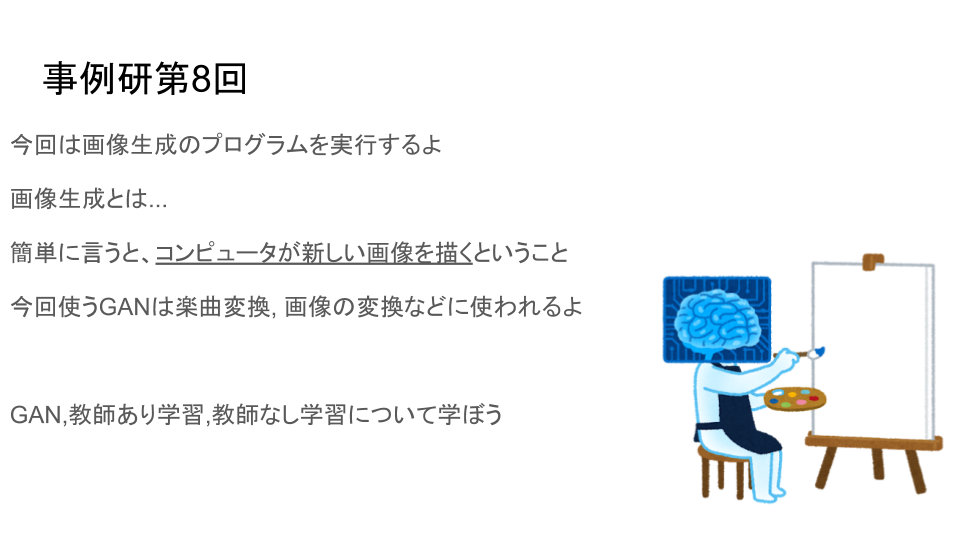

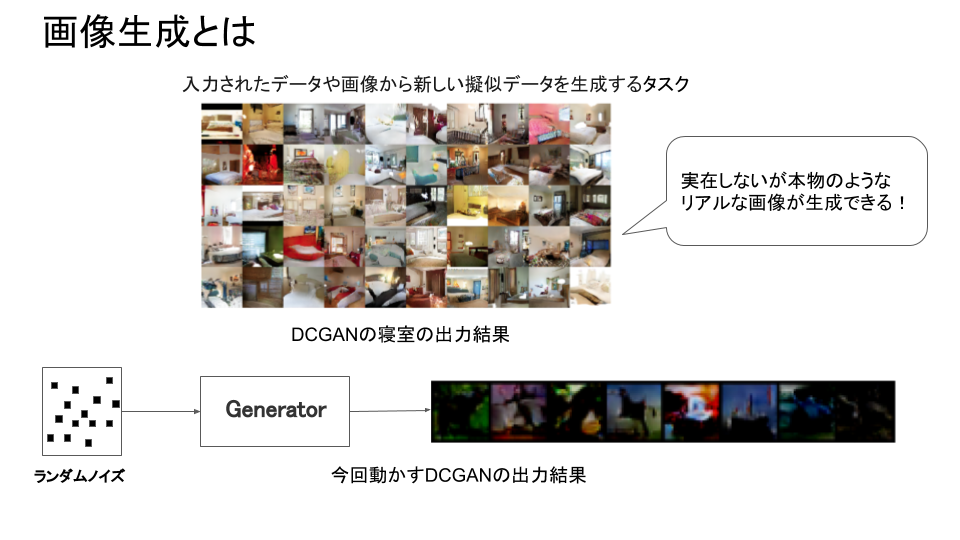

### ライブラリインポート

In [2]:
#このセルはライブラリ(pytorch(機械学習ライブラリ),matplotlib(画像出力用),numpy(行列計算) )のimportをしている(佐藤コメント)
import torch
from torch import optim
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#このセルではdatasetのダウンロード(佐藤メモ)
'''
https://qiita.com/kazetof/items/6a72926b9f8cd44c218e
transformはデータの下処理(テンソルに変換)してtorchの型になるように処理をしている
（佐藤メモ）
Normalizeを変更してあげると、画像の処理が変わり画像の印象が変わるよ
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 100
trainset = CIFAR10('.', train=True, transform=transform, download=True)#trainデータをダウンロードしている(佐藤メモ)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)#trainデータをシャッフルしてbatch_sizeに切り分けたデータにする(佐藤メモ)

Extracting ./cifar-10-python.tar.gz to .


In [15]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    npimg = img.detach().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    #下のコメントアウトされている1行で画像を保存できるよ(毎度上書き保存になるから気を付けて)
    plt.savefig('/content/1821035.jpg')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


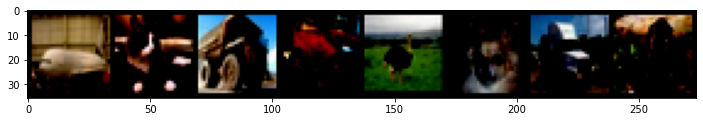

In [5]:
iterator = iter(trainloader)
img, _ = next(iterator)
print(img.shape)
imshow(img[0:8])

In [6]:
class MakeFrom(nn.Module):
    def __init__(self, s):
        super().__init__()
        self.model = s
    def forward(self, x):
        return self.model(x)

### 主要なモジュールの定義

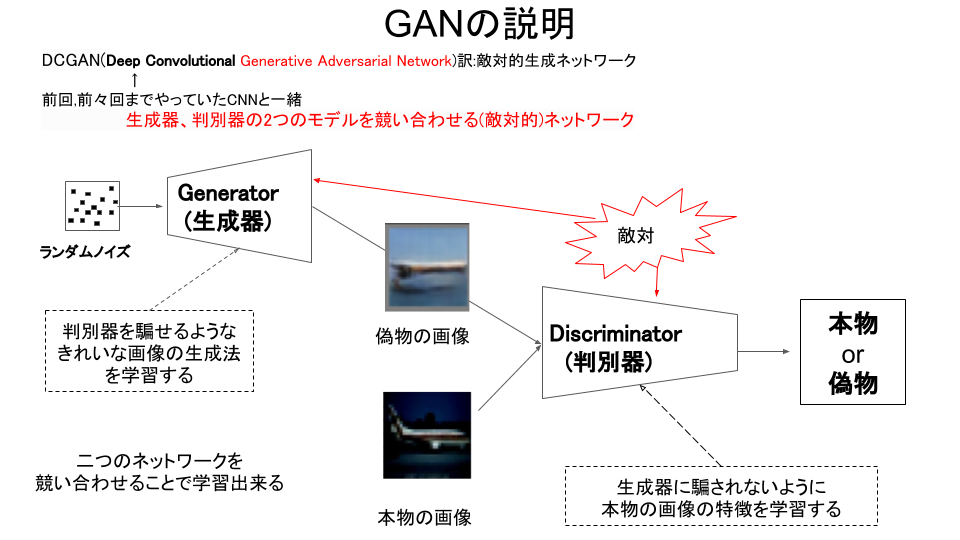

In [7]:
def train(netD, netG, batch_size, zsize, epochs, trainloader):
    losses_netD = []
    losses_netG = []
    out_D_real = []
    out_D_fake = []
    out_G = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    netD = netD.to(device)
    netG = netG.to(device)
    one_labels = torch.ones(batch_size).reshape(batch_size, 1).to(device)
    zero_labels = torch.zeros(batch_size).reshape(batch_size, 1).to(device)
    criterion = nn.BCELoss().to(device)

    optD = optim.Adam(netD.parameters(), lr=0.0002, betas=[0.5, 0.999])
    optG = optim.Adam(netG.parameters(), lr=0.0002, betas=[0.5, 0.999])

    fixed_noise = torch.randn(8, zsize, 1, 1).to(device)
    
    for epoch in range(1, epochs+1):
        running_loss_netD = 0.0
        running_loss_netG = 0.0
        for count, (real_imgs, _) in enumerate(trainloader, 1):
            netD.zero_grad()

            # 識別器の学習
            real_imgs = real_imgs.to(device)
            # データローダーから読み込んだデータを識別器に入力し、損失を計算
            output_real = netD(real_imgs).reshape(batch_size, -1)
            loss_real = criterion(output_real, one_labels)
            
            loss_real.backward()

            # 生成器から得たデータを、識別器に入力し、損失を計算
            z = torch.randn(batch_size, zsize, 1, 1).to(device)
            fake_imgs = netG(z).to(device)
            output_fake1 = netD(fake_imgs.detach()).reshape(batch_size, -1)
            loss_fake1 = criterion(output_fake1, zero_labels)
            loss_fake1.backward()

            # それらをまとめたものが最終的な損失
            loss_netD = loss_real + loss_fake1
            optD.step()
            running_loss_netD += loss_netD  # 1バッチ分の損失の平均値を加算

            # 生成器の学習
            netG.zero_grad()
            z = torch.randn(batch_size, zsize, 1, 1).to(device)
            fake_imgs = netG(z).to(device)
            output_fake2 = netD(fake_imgs).reshape(batch_size, -1)
            loss_netG = criterion(output_fake2, one_labels)
            loss_netG.backward()
            optG.step()
            running_loss_netG += loss_netG # 1バッチ分の損失の平均値を加算

            if epoch == 1:  # 最初のエポックだけ10、20、……、100バッチ終了時の学習状況を表示
                if count < 100 and count % 10 ==0:
                    stat1 = f'epoch: {epoch:02d}, batch: {count}\t'
                    stat2 = f'  lossD: {loss_netD:.4f}(real: {loss_real:.4f}, fake: {loss_fake1:.4f}),'
                    stat3 = f'lossG: {loss_netG:.4f},  D(x): {output_real.mean():.4f},'
                    stat4 = f'D(G(z)): {output_fake1.mean():.4f}, {output_fake2.mean():.4f}'
                    print(stat1, stat2, stat3, stat4)

            if count % 100 == 0:  # 1エポックの中で100回ごとに学習の状況を記録
                out_D_real.append(output_real.mean())
                out_D_fake.append(output_fake1.mean())
                out_G.append(output_fake2.mean())
                stat1 = f'epoch: {epoch:02d}, batch: {count}\t'
                stat2 = f'  lossD: {loss_netD:.4f}(real: {loss_real:.4f}, fake: {loss_fake1:.4f}),'
                stat3 = f'lossG: {loss_netG:.4f},  D(x): {output_real.mean():.4f},'
                stat4 = f'D(G(z)): {output_fake1.mean():.4f}, {output_fake2.mean():.4f}'
                print(stat1, stat2, stat3, stat4)
            
            

        running_loss_netD /= count  # 1エポック終了時にその間の損失の平均を求める
        running_loss_netG /= count
        losses_netD.append(running_loss_netD)
        losses_netG.append(running_loss_netG)
        print(f'epoch: {epoch}, running_loss_D: {running_loss_netD}, running_loss_G: {running_loss_netG}', '\n')

        if epoch % 5 == 0:
            generated_imgs = netG(fixed_noise).cpu()
            imshow(generated_imgs.reshape(8, 3, 32, 32))
            
    return (losses_netD, losses_netG), (out_D_real, out_D_fake, out_G), (netD, netG)

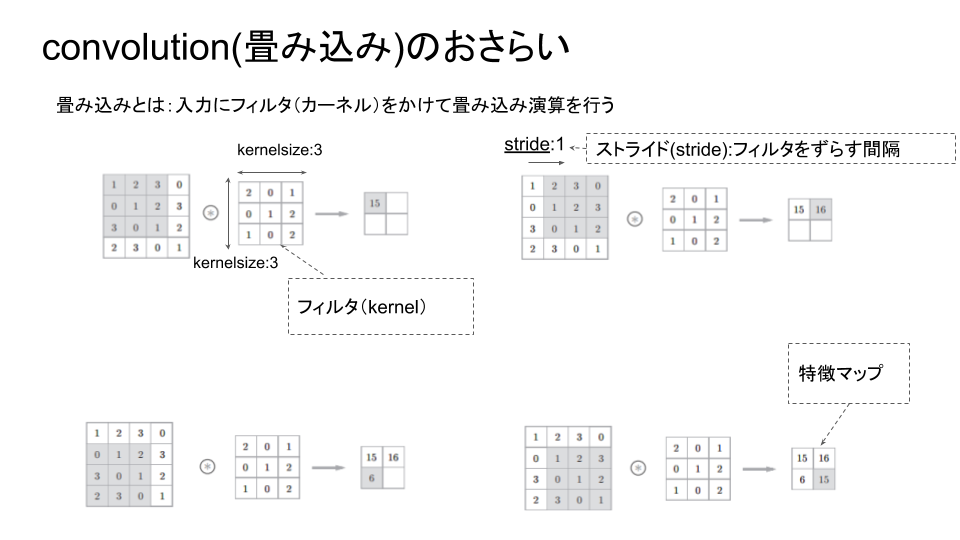

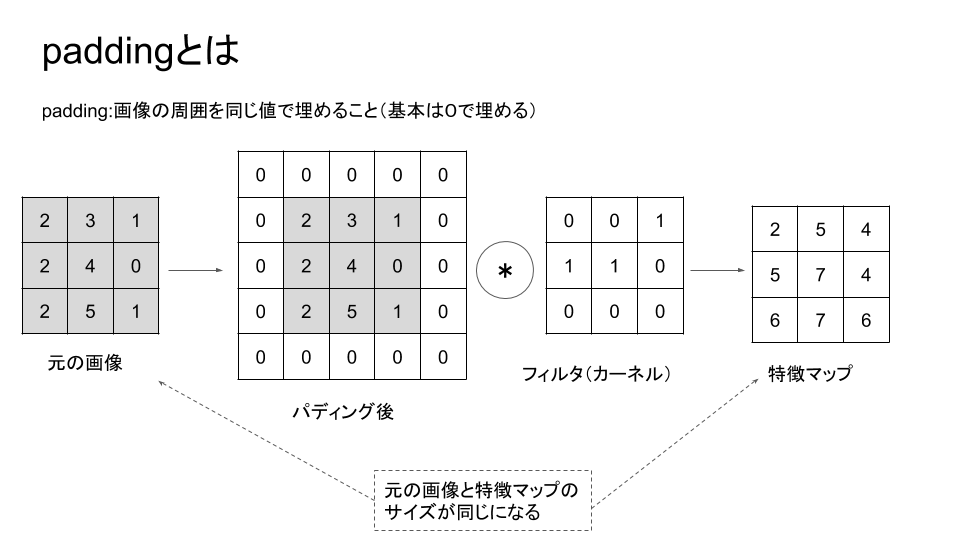

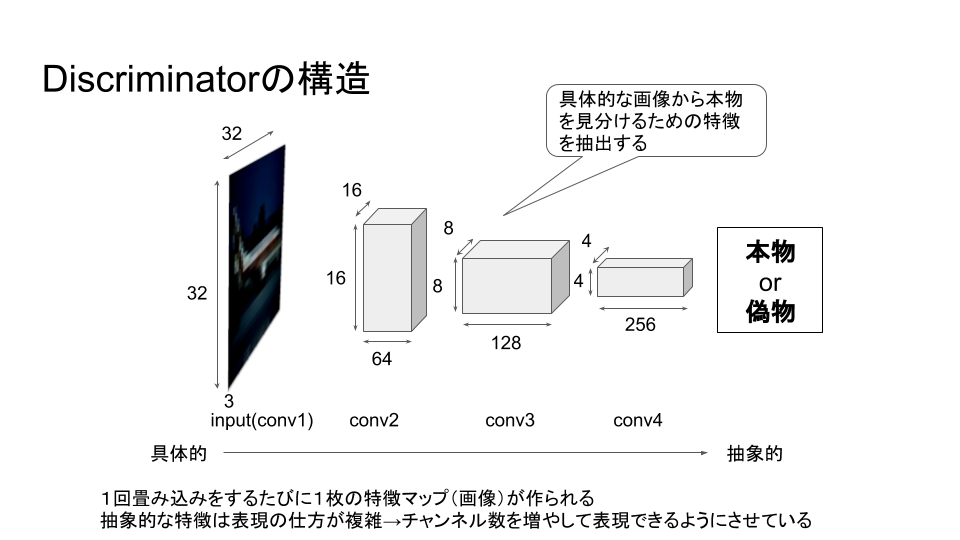

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
)

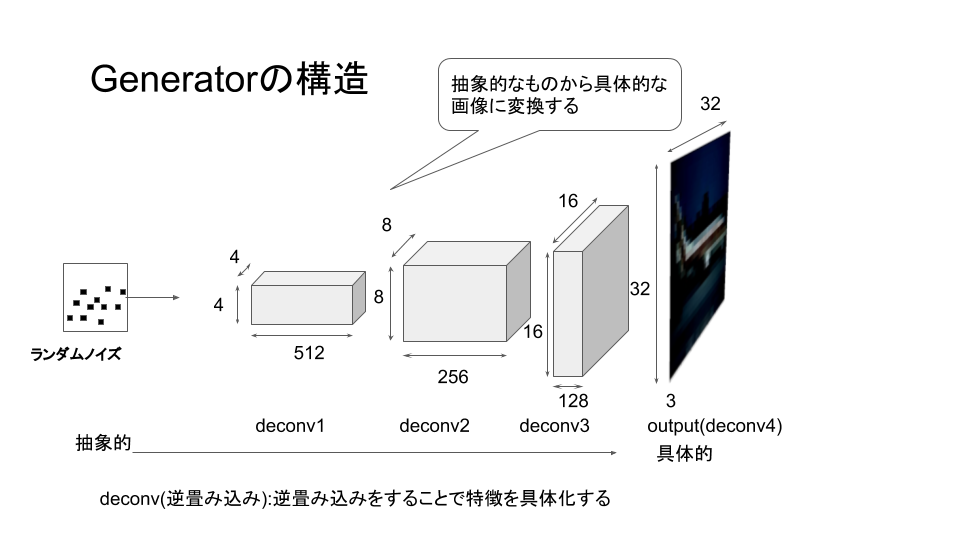

In [10]:
feature_maps = 64
zsize = 100
generator = nn.Sequential(
    nn.ConvTranspose2d(zsize, feature_maps * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(feature_maps * 8),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 4),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 2),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(feature_maps * 2, 3, 4, 2, 1, bias=False),
    nn.Tanh()
)

netD = MakeFrom(discriminator)
netG = MakeFrom(generator)
netD.apply(weights_init)
netG.apply(weights_init)

MakeFrom(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [11]:
iterator = iter(trainloader)
img, _ = next(iterator)

c1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
c2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
c3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
c4 = nn.Conv2d(256, 1, 4, 1, 0, bias=False)
b2 = nn.BatchNorm2d(128)
b3 = nn.BatchNorm2d(256)
relu = nn.LeakyReLU(0.2, inplace=True)
sigmoid = nn.Sigmoid()

x = relu(c1(img))
print(x.shape)
x = relu(b2(c2(x)))
print(x.shape)
x = relu(b3(c3(x)))
print(x.shape)
x = sigmoid(c4(x))
print(x.shape)

print('----')

zsize = 100
t1 = nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False)
bt1 = nn.BatchNorm2d(64 * 8)
t2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
bt2 = nn.BatchNorm2d(64 * 4)
t3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
bt3 = nn.BatchNorm2d(64 * 2)
t4 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1, bias=False)
tanh = nn.Tanh()

z = torch.randn(batch_size, zsize, 1, 1)
x = relu(bt1(t1(z)))
print(x.shape)
x = relu(bt2(t2(x)))
print(x.shape)
x = relu(bt3(t3(x)))
print(x.shape)
x = tanh(t4(x))
print(x.shape)

torch.Size([100, 64, 16, 16])
torch.Size([100, 128, 8, 8])
torch.Size([100, 256, 4, 4])
torch.Size([100, 1, 1, 1])
----
torch.Size([100, 512, 4, 4])
torch.Size([100, 256, 8, 8])
torch.Size([100, 128, 16, 16])
torch.Size([100, 3, 32, 32])


### GANの学習について

lossD:本物の画像を入れたときにどれくらい差があるか , 偽物の画像を入れたときにどれくらいの差があるか\
\
lossG:生成された画像が本物の画像とどれくらい差があるか\
\
D(x):discriminatorが本物と見抜いた割合（精度）\
\
D(G(z)):gen画像を入れたときの見抜いた割合、または騙された割合


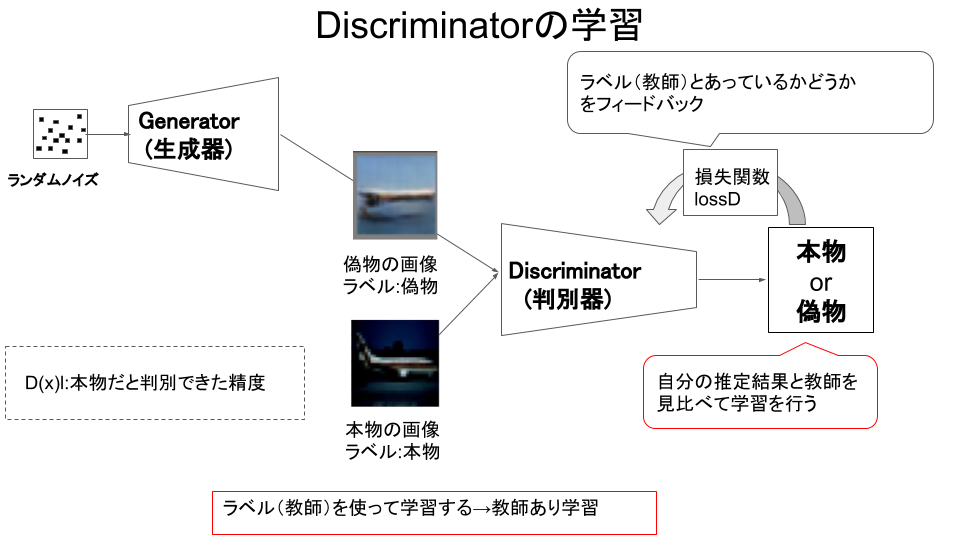

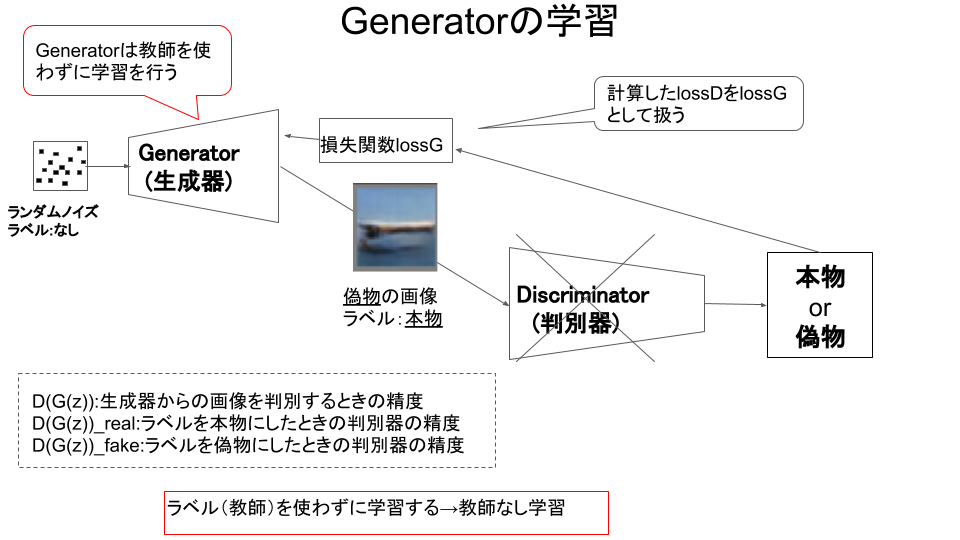

epoch: 01, batch: 10	   lossD: 0.7289(real: 0.3334, fake: 0.3955), lossG: 1.2948,  D(x): 0.7362, D(G(z)): 0.3025, 0.3160
epoch: 01, batch: 20	   lossD: 0.5965(real: 0.2449, fake: 0.3516), lossG: 2.1898,  D(x): 0.7947, D(G(z)): 0.2792, 0.1581
epoch: 01, batch: 30	   lossD: 0.6817(real: 0.1990, fake: 0.4827), lossG: 1.8867,  D(x): 0.8288, D(G(z)): 0.3537, 0.1958
epoch: 01, batch: 40	   lossD: 0.6806(real: 0.1501, fake: 0.5305), lossG: 2.9029,  D(x): 0.8692, D(G(z)): 0.3838, 0.0740
epoch: 01, batch: 50	   lossD: 0.6302(real: 0.3813, fake: 0.2489), lossG: 1.9912,  D(x): 0.7026, D(G(z)): 0.2017, 0.1710
epoch: 01, batch: 60	   lossD: 0.6508(real: 0.4028, fake: 0.2480), lossG: 1.5263,  D(x): 0.6916, D(G(z)): 0.2080, 0.2760
epoch: 01, batch: 70	   lossD: 0.4449(real: 0.2449, fake: 0.1999), lossG: 2.0414,  D(x): 0.7965, D(G(z)): 0.1709, 0.1632
epoch: 01, batch: 80	   lossD: 0.5580(real: 0.2333, fake: 0.3247), lossG: 1.7548,  D(x): 0.8012, D(G(z)): 0.2543, 0.2149
epoch: 01, batch: 90	   lossD: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 05, batch: 500	   lossD: 0.5877(real: 0.4622, fake: 0.1255), lossG: 1.7984,  D(x): 0.6550, D(G(z)): 0.1133, 0.2234
epoch: 5, running_loss_D: 0.7276085019111633, running_loss_G: 1.8356927633285522 



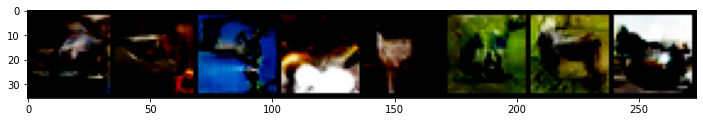

epoch: 06, batch: 100	   lossD: 0.5625(real: 0.2568, fake: 0.3057), lossG: 1.5989,  D(x): 0.7921, D(G(z)): 0.2451, 0.2600
epoch: 06, batch: 200	   lossD: 1.0729(real: 0.1767, fake: 0.8962), lossG: 2.1953,  D(x): 0.8628, D(G(z)): 0.5010, 0.1651
epoch: 06, batch: 300	   lossD: 0.5052(real: 0.2948, fake: 0.2103), lossG: 1.8402,  D(x): 0.7603, D(G(z)): 0.1781, 0.2059
epoch: 06, batch: 400	   lossD: 0.5621(real: 0.2242, fake: 0.3380), lossG: 2.0044,  D(x): 0.8120, D(G(z)): 0.2627, 0.1792
epoch: 06, batch: 500	   lossD: 0.6475(real: 0.2391, fake: 0.4084), lossG: 1.7874,  D(x): 0.7997, D(G(z)): 0.3095, 0.2245
epoch: 6, running_loss_D: 0.7067118883132935, running_loss_G: 1.8581552505493164 

epoch: 07, batch: 100	   lossD: 0.5411(real: 0.3185, fake: 0.2226), lossG: 1.8377,  D(x): 0.7461, D(G(z)): 0.1861, 0.2049
epoch: 07, batch: 200	   lossD: 0.5630(real: 0.1057, fake: 0.4572), lossG: 2.5858,  D(x): 0.9058, D(G(z)): 0.3406, 0.1004
epoch: 07, batch: 300	   lossD: 0.6763(real: 0.3976, fake: 0.27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10, batch: 500	   lossD: 0.6120(real: 0.4978, fake: 0.1142), lossG: 1.6540,  D(x): 0.6402, D(G(z)): 0.1033, 0.2460
epoch: 10, running_loss_D: 0.6931784152984619, running_loss_G: 1.947812795639038 



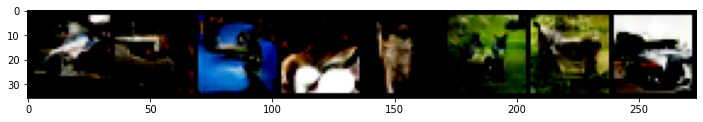

epoch: 11, batch: 100	   lossD: 0.6018(real: 0.2381, fake: 0.3637), lossG: 2.8363,  D(x): 0.8008, D(G(z)): 0.2819, 0.0884
epoch: 11, batch: 200	   lossD: 0.6709(real: 0.4159, fake: 0.2550), lossG: 1.2474,  D(x): 0.6874, D(G(z)): 0.2038, 0.3390
epoch: 11, batch: 300	   lossD: 1.1456(real: 0.0809, fake: 1.0647), lossG: 3.2650,  D(x): 0.9253, D(G(z)): 0.5805, 0.0612
epoch: 11, batch: 400	   lossD: 0.6767(real: 0.4078, fake: 0.2689), lossG: 1.4453,  D(x): 0.6954, D(G(z)): 0.2156, 0.3060
epoch: 11, batch: 500	   lossD: 0.6688(real: 0.3073, fake: 0.3615), lossG: 2.3808,  D(x): 0.7554, D(G(z)): 0.2822, 0.1254
epoch: 11, running_loss_D: 0.671720027923584, running_loss_G: 1.9385844469070435 

epoch: 12, batch: 100	   lossD: 0.7004(real: 0.1441, fake: 0.5564), lossG: 2.1380,  D(x): 0.8715, D(G(z)): 0.3881, 0.1630
epoch: 12, batch: 200	   lossD: 0.6173(real: 0.3918, fake: 0.2255), lossG: 1.7733,  D(x): 0.6946, D(G(z)): 0.1886, 0.2271
epoch: 12, batch: 300	   lossD: 0.6732(real: 0.3264, fake: 0.34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15, batch: 500	   lossD: 0.7504(real: 0.1837, fake: 0.5667), lossG: 2.2983,  D(x): 0.8422, D(G(z)): 0.3864, 0.1551
epoch: 15, running_loss_D: 0.6560275554656982, running_loss_G: 2.0074973106384277 



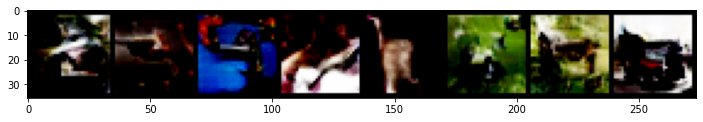

epoch: 16, batch: 100	   lossD: 0.5555(real: 0.1375, fake: 0.4180), lossG: 2.4190,  D(x): 0.8762, D(G(z)): 0.3060, 0.1272
epoch: 16, batch: 200	   lossD: 0.7372(real: 0.1034, fake: 0.6338), lossG: 2.5606,  D(x): 0.9064, D(G(z)): 0.4192, 0.1063
epoch: 16, batch: 300	   lossD: 0.6239(real: 0.1825, fake: 0.4415), lossG: 2.3694,  D(x): 0.8451, D(G(z)): 0.3145, 0.1397
epoch: 16, batch: 400	   lossD: 0.4918(real: 0.2369, fake: 0.2549), lossG: 2.4250,  D(x): 0.8020, D(G(z)): 0.2065, 0.1261
epoch: 16, batch: 500	   lossD: 0.8031(real: 0.5653, fake: 0.2378), lossG: 0.7078,  D(x): 0.6116, D(G(z)): 0.1945, 0.5498
epoch: 16, running_loss_D: 0.5836706161499023, running_loss_G: 2.0425262451171875 

epoch: 17, batch: 100	   lossD: 0.5344(real: 0.3041, fake: 0.2303), lossG: 1.6031,  D(x): 0.7565, D(G(z)): 0.1939, 0.2619
epoch: 17, batch: 200	   lossD: 0.8869(real: 0.8092, fake: 0.0777), lossG: 0.5972,  D(x): 0.5067, D(G(z)): 0.0712, 0.6049
epoch: 17, batch: 300	   lossD: 0.4307(real: 0.2301, fake: 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, batch: 500	   lossD: 0.4029(real: 0.1183, fake: 0.2846), lossG: 2.1286,  D(x): 0.8916, D(G(z)): 0.2257, 0.1728
epoch: 20, running_loss_D: 0.6141361594200134, running_loss_G: 2.1237895488739014 



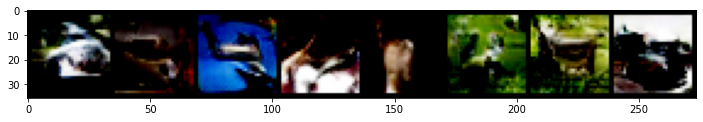

epoch: 21, batch: 100	   lossD: 0.4648(real: 0.3254, fake: 0.1394), lossG: 1.4863,  D(x): 0.7416, D(G(z)): 0.1248, 0.2794
epoch: 21, batch: 200	   lossD: 0.4833(real: 0.2845, fake: 0.1988), lossG: 2.1810,  D(x): 0.7736, D(G(z)): 0.1624, 0.1592
epoch: 21, batch: 300	   lossD: 0.6053(real: 0.2076, fake: 0.3976), lossG: 2.5250,  D(x): 0.8244, D(G(z)): 0.2958, 0.1244
epoch: 21, batch: 400	   lossD: 0.6023(real: 0.2167, fake: 0.3856), lossG: 2.1076,  D(x): 0.8205, D(G(z)): 0.2924, 0.1772
epoch: 21, batch: 500	   lossD: 0.5364(real: 0.2540, fake: 0.2824), lossG: 1.9455,  D(x): 0.7918, D(G(z)): 0.2219, 0.1957
epoch: 21, running_loss_D: 0.5814788937568665, running_loss_G: 2.1382431983947754 

epoch: 22, batch: 100	   lossD: 0.6945(real: 0.5954, fake: 0.0991), lossG: 1.6704,  D(x): 0.5889, D(G(z)): 0.0907, 0.2515
epoch: 22, batch: 200	   lossD: 4.3973(real: 4.3908, fake: 0.0065), lossG: 0.0318,  D(x): 0.0458, D(G(z)): 0.0064, 0.9699
epoch: 22, batch: 300	   lossD: 0.3710(real: 0.2114, fake: 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25, batch: 500	   lossD: 0.5520(real: 0.0657, fake: 0.4863), lossG: 2.6794,  D(x): 0.9379, D(G(z)): 0.3500, 0.1152
epoch: 25, running_loss_D: 0.5927414894104004, running_loss_G: 2.1904306411743164 



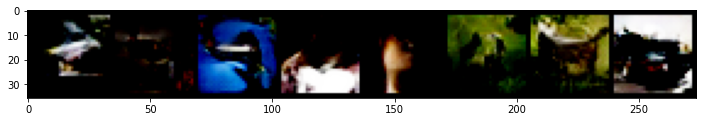

epoch: 26, batch: 100	   lossD: 0.3243(real: 0.1844, fake: 0.1399), lossG: 1.6815,  D(x): 0.8395, D(G(z)): 0.1210, 0.2442
epoch: 26, batch: 200	   lossD: 0.4418(real: 0.1571, fake: 0.2847), lossG: 2.8505,  D(x): 0.8683, D(G(z)): 0.2247, 0.0893
epoch: 26, batch: 300	   lossD: 0.5519(real: 0.3898, fake: 0.1620), lossG: 2.3851,  D(x): 0.7179, D(G(z)): 0.1386, 0.1540
epoch: 26, batch: 400	   lossD: 0.5568(real: 0.1772, fake: 0.3796), lossG: 2.2264,  D(x): 0.8493, D(G(z)): 0.2760, 0.1685
epoch: 26, batch: 500	   lossD: 1.4970(real: 0.1563, fake: 1.3407), lossG: 1.6640,  D(x): 0.8767, D(G(z)): 0.6193, 0.2838
epoch: 26, running_loss_D: 0.6018772721290588, running_loss_G: 2.2502522468566895 

epoch: 27, batch: 100	   lossD: 0.3838(real: 0.1931, fake: 0.1907), lossG: 1.6536,  D(x): 0.8370, D(G(z)): 0.1600, 0.2623
epoch: 27, batch: 200	   lossD: 0.6968(real: 0.6151, fake: 0.0817), lossG: 1.3779,  D(x): 0.5768, D(G(z)): 0.0751, 0.3535
epoch: 27, batch: 300	   lossD: 0.8588(real: 0.1213, fake: 0.7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30, batch: 500	   lossD: 0.5566(real: 0.1299, fake: 0.4267), lossG: 2.5572,  D(x): 0.8847, D(G(z)): 0.2956, 0.1194
epoch: 30, running_loss_D: 0.5561763644218445, running_loss_G: 2.265411138534546 



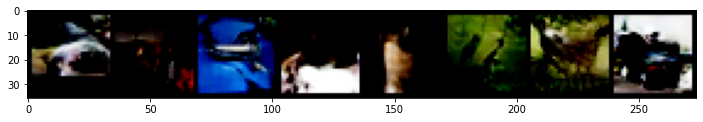

epoch: 31, batch: 100	   lossD: 0.4988(real: 0.2800, fake: 0.2188), lossG: 2.3923,  D(x): 0.7688, D(G(z)): 0.1750, 0.1459
epoch: 31, batch: 200	   lossD: 2.8475(real: 2.8433, fake: 0.0042), lossG: 0.1754,  D(x): 0.1157, D(G(z)): 0.0042, 0.8612
epoch: 31, batch: 300	   lossD: 0.5013(real: 0.4216, fake: 0.0797), lossG: 2.2069,  D(x): 0.6891, D(G(z)): 0.0723, 0.1807
epoch: 31, batch: 400	   lossD: 0.4174(real: 0.1566, fake: 0.2608), lossG: 2.1000,  D(x): 0.8622, D(G(z)): 0.2106, 0.1802
epoch: 31, batch: 500	   lossD: 0.5053(real: 0.4158, fake: 0.0894), lossG: 1.9296,  D(x): 0.6909, D(G(z)): 0.0813, 0.2204
epoch: 31, running_loss_D: 0.5505741834640503, running_loss_G: 2.251335620880127 

epoch: 32, batch: 100	   lossD: 0.5242(real: 0.4343, fake: 0.0900), lossG: 1.4500,  D(x): 0.6730, D(G(z)): 0.0825, 0.3244
epoch: 32, batch: 200	   lossD: 0.3957(real: 0.2126, fake: 0.1831), lossG: 1.9766,  D(x): 0.8192, D(G(z)): 0.1586, 0.1943
epoch: 32, batch: 300	   lossD: 0.7813(real: 0.0670, fake: 0.71

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 35, batch: 500	   lossD: 0.4381(real: 0.1953, fake: 0.2427), lossG: 2.0689,  D(x): 0.8353, D(G(z)): 0.1951, 0.1935
epoch: 35, running_loss_D: 0.5420426726341248, running_loss_G: 2.3541760444641113 



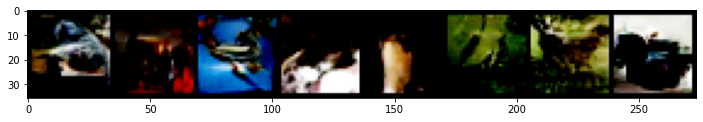

epoch: 36, batch: 100	   lossD: 0.3632(real: 0.1972, fake: 0.1659), lossG: 2.2100,  D(x): 0.8337, D(G(z)): 0.1432, 0.1578
epoch: 36, batch: 200	   lossD: 0.3975(real: 0.1628, fake: 0.2347), lossG: 2.0517,  D(x): 0.8598, D(G(z)): 0.1896, 0.2016
epoch: 36, batch: 300	   lossD: 0.6745(real: 0.3759, fake: 0.2986), lossG: 2.1220,  D(x): 0.7139, D(G(z)): 0.2359, 0.1882
epoch: 36, batch: 400	   lossD: 0.5206(real: 0.3047, fake: 0.2159), lossG: 2.4245,  D(x): 0.7628, D(G(z)): 0.1721, 0.1401
epoch: 36, batch: 500	   lossD: 0.4158(real: 0.1686, fake: 0.2472), lossG: 2.1051,  D(x): 0.8544, D(G(z)): 0.2003, 0.1824
epoch: 36, running_loss_D: 0.5268760919570923, running_loss_G: 2.373727321624756 

epoch: 37, batch: 100	   lossD: 0.4585(real: 0.2968, fake: 0.1617), lossG: 2.0167,  D(x): 0.7603, D(G(z)): 0.1395, 0.2137
epoch: 37, batch: 200	   lossD: 0.5130(real: 0.3126, fake: 0.2004), lossG: 2.6053,  D(x): 0.7631, D(G(z)): 0.1614, 0.1105
epoch: 37, batch: 300	   lossD: 0.3728(real: 0.1803, fake: 0.19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40, batch: 500	   lossD: 0.5871(real: 0.4434, fake: 0.1437), lossG: 1.6379,  D(x): 0.6712, D(G(z)): 0.1251, 0.2823
epoch: 40, running_loss_D: 0.615549623966217, running_loss_G: 2.381627082824707 



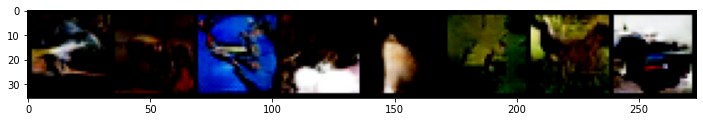

epoch: 41, batch: 100	   lossD: 2.5261(real: 2.4579, fake: 0.0681), lossG: 0.5041,  D(x): 0.1788, D(G(z)): 0.0617, 0.6678
epoch: 41, batch: 200	   lossD: 0.5043(real: 0.1359, fake: 0.3684), lossG: 2.1987,  D(x): 0.8829, D(G(z)): 0.2786, 0.1789
epoch: 41, batch: 300	   lossD: 0.3966(real: 0.3235, fake: 0.0730), lossG: 1.4842,  D(x): 0.7469, D(G(z)): 0.0683, 0.3154
epoch: 41, batch: 400	   lossD: 0.3877(real: 0.2044, fake: 0.1833), lossG: 2.3734,  D(x): 0.8263, D(G(z)): 0.1495, 0.1619
epoch: 41, batch: 500	   lossD: 0.4165(real: 0.1853, fake: 0.2312), lossG: 2.7021,  D(x): 0.8443, D(G(z)): 0.1844, 0.1150
epoch: 41, running_loss_D: 0.5544071197509766, running_loss_G: 2.414937973022461 

epoch: 42, batch: 100	   lossD: 0.3536(real: 0.2266, fake: 0.1270), lossG: 1.7589,  D(x): 0.8158, D(G(z)): 0.1105, 0.2428
epoch: 42, batch: 200	   lossD: 0.9779(real: 0.9546, fake: 0.0234), lossG: 1.6108,  D(x): 0.4623, D(G(z)): 0.0221, 0.3057
epoch: 42, batch: 300	   lossD: 0.4618(real: 0.1158, fake: 0.34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 45, batch: 500	   lossD: 0.4460(real: 0.3559, fake: 0.0901), lossG: 1.4631,  D(x): 0.7263, D(G(z)): 0.0831, 0.3165
epoch: 45, running_loss_D: 0.4769369661808014, running_loss_G: 2.487046718597412 



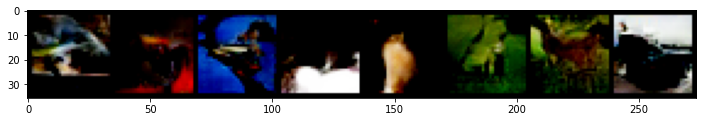

epoch: 46, batch: 100	   lossD: 0.3866(real: 0.1008, fake: 0.2858), lossG: 2.5460,  D(x): 0.9098, D(G(z)): 0.2167, 0.1378
epoch: 46, batch: 200	   lossD: 0.4919(real: 0.0396, fake: 0.4523), lossG: 2.7587,  D(x): 0.9632, D(G(z)): 0.3159, 0.1140
epoch: 46, batch: 300	   lossD: 0.3675(real: 0.2127, fake: 0.1547), lossG: 2.7471,  D(x): 0.8211, D(G(z)): 0.1312, 0.0981
epoch: 46, batch: 400	   lossD: 0.4317(real: 0.2071, fake: 0.2246), lossG: 2.8811,  D(x): 0.8247, D(G(z)): 0.1816, 0.1063
epoch: 46, batch: 500	   lossD: 0.4995(real: 0.0661, fake: 0.4334), lossG: 2.6532,  D(x): 0.9395, D(G(z)): 0.3111, 0.1235
epoch: 46, running_loss_D: 0.48713916540145874, running_loss_G: 2.490885019302368 

epoch: 47, batch: 100	   lossD: 0.3514(real: 0.1898, fake: 0.1616), lossG: 2.0788,  D(x): 0.8396, D(G(z)): 0.1276, 0.2034
epoch: 47, batch: 200	   lossD: 0.3841(real: 0.0863, fake: 0.2978), lossG: 2.5653,  D(x): 0.9202, D(G(z)): 0.2265, 0.1250
epoch: 47, batch: 300	   lossD: 0.3924(real: 0.2344, fake: 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 50, batch: 500	   lossD: 1.4139(real: 0.0225, fake: 1.3914), lossG: 5.5608,  D(x): 0.9781, D(G(z)): 0.6448, 0.0146
epoch: 50, running_loss_D: 0.44718873500823975, running_loss_G: 2.584678888320923 



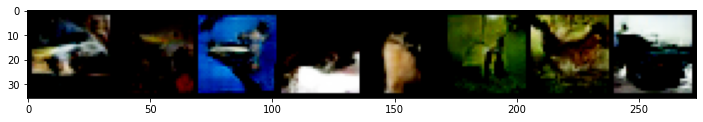

epoch: 51, batch: 100	   lossD: 0.2834(real: 0.1473, fake: 0.1361), lossG: 2.6591,  D(x): 0.8691, D(G(z)): 0.1120, 0.1199
epoch: 51, batch: 200	   lossD: 0.4128(real: 0.2364, fake: 0.1763), lossG: 2.1062,  D(x): 0.8101, D(G(z)): 0.1470, 0.1986
epoch: 51, batch: 300	   lossD: 0.3282(real: 0.2076, fake: 0.1206), lossG: 2.4049,  D(x): 0.8317, D(G(z)): 0.1089, 0.1468
epoch: 51, batch: 400	   lossD: 0.3624(real: 0.1106, fake: 0.2519), lossG: 3.4972,  D(x): 0.8986, D(G(z)): 0.1980, 0.0560
epoch: 51, batch: 500	   lossD: 0.3654(real: 0.0550, fake: 0.3104), lossG: 2.3044,  D(x): 0.9479, D(G(z)): 0.2376, 0.1489
epoch: 51, running_loss_D: 0.5349528193473816, running_loss_G: 2.5379974842071533 

epoch: 52, batch: 100	   lossD: 0.2114(real: 0.0916, fake: 0.1198), lossG: 3.2685,  D(x): 0.9154, D(G(z)): 0.1021, 0.0776
epoch: 52, batch: 200	   lossD: 0.4029(real: 0.0649, fake: 0.3380), lossG: 3.2449,  D(x): 0.9408, D(G(z)): 0.2572, 0.0839
epoch: 52, batch: 300	   lossD: 0.3593(real: 0.2686, fake: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 55, batch: 500	   lossD: 0.3742(real: 0.3473, fake: 0.0269), lossG: 3.4783,  D(x): 0.7316, D(G(z)): 0.0262, 0.0543
epoch: 55, running_loss_D: 0.4457681179046631, running_loss_G: 2.586487293243408 



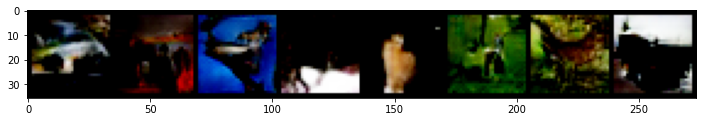

epoch: 56, batch: 100	   lossD: 0.3311(real: 0.1273, fake: 0.2038), lossG: 2.2297,  D(x): 0.8858, D(G(z)): 0.1658, 0.2019
epoch: 56, batch: 200	   lossD: 0.3234(real: 0.0478, fake: 0.2756), lossG: 3.8093,  D(x): 0.9552, D(G(z)): 0.2118, 0.0478
epoch: 56, batch: 300	   lossD: 0.3401(real: 0.1542, fake: 0.1859), lossG: 2.6644,  D(x): 0.8637, D(G(z)): 0.1550, 0.1201
epoch: 56, batch: 400	   lossD: 0.5220(real: 0.1533, fake: 0.3687), lossG: 2.2575,  D(x): 0.8681, D(G(z)): 0.2637, 0.1826
epoch: 56, batch: 500	   lossD: 0.3062(real: 0.1912, fake: 0.1150), lossG: 3.0702,  D(x): 0.8377, D(G(z)): 0.0972, 0.0855
epoch: 56, running_loss_D: 0.4638501703739166, running_loss_G: 2.6249451637268066 

epoch: 57, batch: 100	   lossD: 0.3321(real: 0.1858, fake: 0.1464), lossG: 2.1783,  D(x): 0.8404, D(G(z)): 0.1257, 0.1690
epoch: 57, batch: 200	   lossD: 0.3085(real: 0.0662, fake: 0.2423), lossG: 3.5307,  D(x): 0.9386, D(G(z)): 0.1985, 0.0607
epoch: 57, batch: 300	   lossD: 0.4272(real: 0.0464, fake: 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 60, batch: 500	   lossD: 1.0085(real: 0.8633, fake: 0.1452), lossG: 0.6618,  D(x): 0.5345, D(G(z)): 0.1087, 0.6274
epoch: 60, running_loss_D: 0.43618541955947876, running_loss_G: 2.6775035858154297 



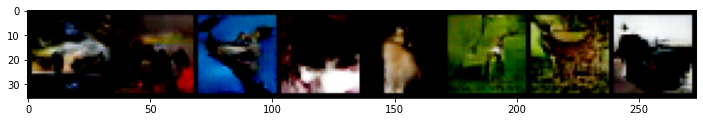

epoch: 61, batch: 100	   lossD: 0.3868(real: 0.1780, fake: 0.2088), lossG: 2.6636,  D(x): 0.8453, D(G(z)): 0.1643, 0.1088
epoch: 61, batch: 200	   lossD: 0.3162(real: 0.0951, fake: 0.2211), lossG: 3.3330,  D(x): 0.9136, D(G(z)): 0.1757, 0.0762
epoch: 61, batch: 300	   lossD: 0.3653(real: 0.2729, fake: 0.0925), lossG: 2.6215,  D(x): 0.7857, D(G(z)): 0.0832, 0.1306
epoch: 61, batch: 400	   lossD: 0.2984(real: 0.2147, fake: 0.0836), lossG: 2.6499,  D(x): 0.8190, D(G(z)): 0.0771, 0.1329
epoch: 61, batch: 500	   lossD: 0.6649(real: 0.2037, fake: 0.4612), lossG: 2.3231,  D(x): 0.8365, D(G(z)): 0.3103, 0.1787
epoch: 61, running_loss_D: 0.665647029876709, running_loss_G: 2.6827869415283203 

epoch: 62, batch: 100	   lossD: 0.3531(real: 0.1633, fake: 0.1898), lossG: 2.4291,  D(x): 0.8668, D(G(z)): 0.1546, 0.1399
epoch: 62, batch: 200	   lossD: 0.3409(real: 0.0754, fake: 0.2656), lossG: 3.1677,  D(x): 0.9298, D(G(z)): 0.2018, 0.0798
epoch: 62, batch: 300	   lossD: 0.4088(real: 0.3204, fake: 0.08

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 65, batch: 500	   lossD: 0.3732(real: 0.1714, fake: 0.2018), lossG: 2.9817,  D(x): 0.8570, D(G(z)): 0.1488, 0.0930
epoch: 65, running_loss_D: 0.4469520151615143, running_loss_G: 2.7113828659057617 



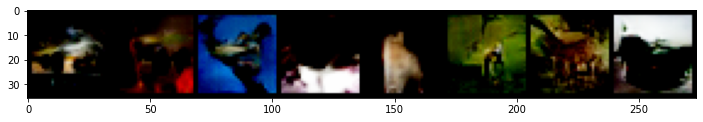

epoch: 66, batch: 100	   lossD: 0.3902(real: 0.2556, fake: 0.1346), lossG: 2.1905,  D(x): 0.7919, D(G(z)): 0.1141, 0.1926
epoch: 66, batch: 200	   lossD: 0.3568(real: 0.3075, fake: 0.0493), lossG: 3.0854,  D(x): 0.7726, D(G(z)): 0.0458, 0.0924
epoch: 66, batch: 300	   lossD: 0.4293(real: 0.3039, fake: 0.1254), lossG: 2.1032,  D(x): 0.7630, D(G(z)): 0.1076, 0.1999
epoch: 66, batch: 400	   lossD: 0.4341(real: 0.2145, fake: 0.2196), lossG: 2.5298,  D(x): 0.8228, D(G(z)): 0.1700, 0.1612
epoch: 66, batch: 500	   lossD: 0.3834(real: 0.1669, fake: 0.2165), lossG: 1.8586,  D(x): 0.8573, D(G(z)): 0.1686, 0.2508
epoch: 66, running_loss_D: 0.46103420853614807, running_loss_G: 2.7148234844207764 

epoch: 67, batch: 100	   lossD: 0.2668(real: 0.1135, fake: 0.1533), lossG: 2.1542,  D(x): 0.8993, D(G(z)): 0.1309, 0.2028
epoch: 67, batch: 200	   lossD: 0.3279(real: 0.2041, fake: 0.1238), lossG: 2.4552,  D(x): 0.8303, D(G(z)): 0.1094, 0.1576
epoch: 67, batch: 300	   lossD: 2.9219(real: 2.9088, fake: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 70, batch: 500	   lossD: 0.3320(real: 0.1382, fake: 0.1938), lossG: 2.9813,  D(x): 0.8812, D(G(z)): 0.1606, 0.0945
epoch: 70, running_loss_D: 0.47351858019828796, running_loss_G: 2.808476686477661 



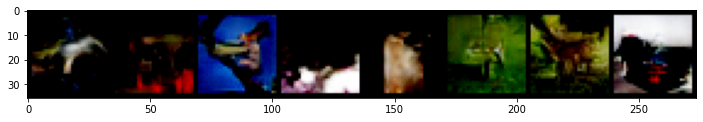

epoch: 71, batch: 100	   lossD: 0.2488(real: 0.1382, fake: 0.1105), lossG: 1.8443,  D(x): 0.8762, D(G(z)): 0.0993, 0.2314
epoch: 71, batch: 200	   lossD: 0.4903(real: 0.3717, fake: 0.1185), lossG: 1.7091,  D(x): 0.7156, D(G(z)): 0.1000, 0.2830
epoch: 71, batch: 300	   lossD: 0.2928(real: 0.2263, fake: 0.0665), lossG: 1.9878,  D(x): 0.8139, D(G(z)): 0.0619, 0.2245
epoch: 71, batch: 400	   lossD: 0.2936(real: 0.2351, fake: 0.0585), lossG: 1.6765,  D(x): 0.8070, D(G(z)): 0.0548, 0.2633
epoch: 71, batch: 500	   lossD: 0.3475(real: 0.1366, fake: 0.2108), lossG: 2.6535,  D(x): 0.8807, D(G(z)): 0.1730, 0.1148
epoch: 71, running_loss_D: 0.4192540645599365, running_loss_G: 2.766655445098877 

epoch: 72, batch: 100	   lossD: 0.4281(real: 0.0222, fake: 0.4060), lossG: 2.8931,  D(x): 0.9784, D(G(z)): 0.2937, 0.1037
epoch: 72, batch: 200	   lossD: 0.4081(real: 0.0511, fake: 0.3570), lossG: 3.6637,  D(x): 0.9515, D(G(z)): 0.2641, 0.0492
epoch: 72, batch: 300	   lossD: 0.3968(real: 0.1227, fake: 0.27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 75, batch: 500	   lossD: 0.3736(real: 0.1959, fake: 0.1776), lossG: 2.3218,  D(x): 0.8445, D(G(z)): 0.1467, 0.1789
epoch: 75, running_loss_D: 0.4066329002380371, running_loss_G: 2.8235130310058594 



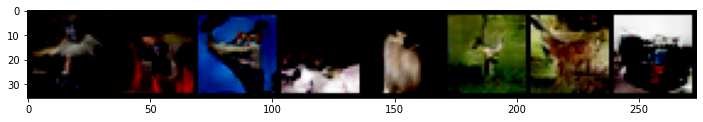

epoch: 76, batch: 100	   lossD: 0.3072(real: 0.0809, fake: 0.2262), lossG: 2.9488,  D(x): 0.9253, D(G(z)): 0.1744, 0.0966
epoch: 76, batch: 200	   lossD: 0.3937(real: 0.0592, fake: 0.3345), lossG: 4.6625,  D(x): 0.9448, D(G(z)): 0.2377, 0.0250
epoch: 76, batch: 300	   lossD: 0.1995(real: 0.0892, fake: 0.1103), lossG: 2.8482,  D(x): 0.9181, D(G(z)): 0.0988, 0.1056
epoch: 76, batch: 400	   lossD: 1.3638(real: 1.2852, fake: 0.0786), lossG: 0.6012,  D(x): 0.3975, D(G(z)): 0.0628, 0.6779
epoch: 76, batch: 500	   lossD: 0.3391(real: 0.2527, fake: 0.0864), lossG: 2.3878,  D(x): 0.7985, D(G(z)): 0.0775, 0.1526
epoch: 76, running_loss_D: 0.4129769504070282, running_loss_G: 2.836484432220459 

epoch: 77, batch: 100	   lossD: 0.4938(real: 0.4184, fake: 0.0754), lossG: 1.4662,  D(x): 0.6979, D(G(z)): 0.0690, 0.3425
epoch: 77, batch: 200	   lossD: 0.4572(real: 0.3038, fake: 0.1534), lossG: 3.5952,  D(x): 0.7711, D(G(z)): 0.1220, 0.0697
epoch: 77, batch: 300	   lossD: 0.3593(real: 0.2577, fake: 0.10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 80, batch: 500	   lossD: 0.2200(real: 0.0537, fake: 0.1663), lossG: 3.8346,  D(x): 0.9486, D(G(z)): 0.1345, 0.0400
epoch: 80, running_loss_D: 0.4194275438785553, running_loss_G: 2.89357852935791 



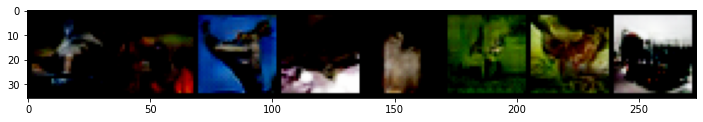

epoch: 81, batch: 100	   lossD: 0.3356(real: 0.0676, fake: 0.2680), lossG: 3.2318,  D(x): 0.9381, D(G(z)): 0.1986, 0.0916
epoch: 81, batch: 200	   lossD: 0.3119(real: 0.0994, fake: 0.2125), lossG: 3.4093,  D(x): 0.9098, D(G(z)): 0.1717, 0.0577
epoch: 81, batch: 300	   lossD: 0.1794(real: 0.0460, fake: 0.1334), lossG: 3.7002,  D(x): 0.9570, D(G(z)): 0.1003, 0.0559
epoch: 81, batch: 400	   lossD: 0.2788(real: 0.1327, fake: 0.1461), lossG: 3.0252,  D(x): 0.8869, D(G(z)): 0.1233, 0.0865
epoch: 81, batch: 500	   lossD: 0.3175(real: 0.1383, fake: 0.1792), lossG: 3.2665,  D(x): 0.8797, D(G(z)): 0.1477, 0.0924
epoch: 81, running_loss_D: 0.38666167855262756, running_loss_G: 2.9302306175231934 

epoch: 82, batch: 100	   lossD: 0.2466(real: 0.1559, fake: 0.0907), lossG: 4.1483,  D(x): 0.8665, D(G(z)): 0.0796, 0.0384
epoch: 82, batch: 200	   lossD: 0.1691(real: 0.0712, fake: 0.0979), lossG: 2.8749,  D(x): 0.9341, D(G(z)): 0.0848, 0.1061
epoch: 82, batch: 300	   lossD: 0.2931(real: 0.0930, fake: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 85, batch: 500	   lossD: 0.2431(real: 0.0943, fake: 0.1489), lossG: 3.0734,  D(x): 0.9146, D(G(z)): 0.1235, 0.0869
epoch: 85, running_loss_D: 0.3309411108493805, running_loss_G: 2.984287977218628 



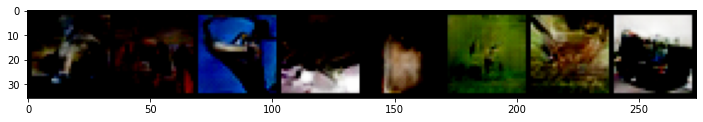

epoch: 86, batch: 100	   lossD: 9.2549(real: 0.0011, fake: 9.2538), lossG: 9.5746,  D(x): 0.9989, D(G(z)): 0.9892, 0.0280
epoch: 86, batch: 200	   lossD: 0.3819(real: 0.0728, fake: 0.3091), lossG: 4.0515,  D(x): 0.9352, D(G(z)): 0.2321, 0.0480
epoch: 86, batch: 300	   lossD: 0.2112(real: 0.1173, fake: 0.0939), lossG: 3.6517,  D(x): 0.8946, D(G(z)): 0.0841, 0.0552
epoch: 86, batch: 400	   lossD: 0.3770(real: 0.0247, fake: 0.3524), lossG: 3.5554,  D(x): 0.9768, D(G(z)): 0.2622, 0.0671
epoch: 86, batch: 500	   lossD: 0.3222(real: 0.1237, fake: 0.1985), lossG: 3.0075,  D(x): 0.8916, D(G(z)): 0.1625, 0.0957
epoch: 86, running_loss_D: 0.4098314642906189, running_loss_G: 2.9623312950134277 

epoch: 87, batch: 100	   lossD: 0.5409(real: 0.3137, fake: 0.2273), lossG: 1.4049,  D(x): 0.7804, D(G(z)): 0.1629, 0.4116
epoch: 87, batch: 200	   lossD: 0.4203(real: 0.0364, fake: 0.3838), lossG: 3.9424,  D(x): 0.9651, D(G(z)): 0.2677, 0.0513
epoch: 87, batch: 300	   lossD: 0.3689(real: 0.1133, fake: 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 90, batch: 500	   lossD: 0.4308(real: 0.0863, fake: 0.3444), lossG: 2.9494,  D(x): 0.9220, D(G(z)): 0.2512, 0.1134
epoch: 90, running_loss_D: 0.38530319929122925, running_loss_G: 3.037022352218628 



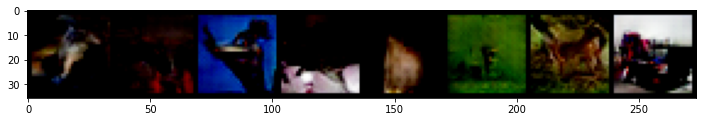

epoch: 91, batch: 100	   lossD: 0.2485(real: 0.1608, fake: 0.0877), lossG: 2.6272,  D(x): 0.8614, D(G(z)): 0.0784, 0.1455
epoch: 91, batch: 200	   lossD: 0.2924(real: 0.0856, fake: 0.2068), lossG: 3.1223,  D(x): 0.9217, D(G(z)): 0.1694, 0.0893
epoch: 91, batch: 300	   lossD: 0.2407(real: 0.0631, fake: 0.1776), lossG: 3.7007,  D(x): 0.9421, D(G(z)): 0.1497, 0.0554
epoch: 91, batch: 400	   lossD: 0.3193(real: 0.2440, fake: 0.0753), lossG: 2.6866,  D(x): 0.8026, D(G(z)): 0.0662, 0.1127
epoch: 91, batch: 500	   lossD: 0.1955(real: 0.1109, fake: 0.0846), lossG: 4.1367,  D(x): 0.9032, D(G(z)): 0.0753, 0.0405
epoch: 91, running_loss_D: 0.33213603496551514, running_loss_G: 3.0439226627349854 

epoch: 92, batch: 100	   lossD: 0.4428(real: 0.1084, fake: 0.3344), lossG: 3.7278,  D(x): 0.9055, D(G(z)): 0.2301, 0.0535
epoch: 92, batch: 200	   lossD: 0.2487(real: 0.1403, fake: 0.1084), lossG: 3.0231,  D(x): 0.8799, D(G(z)): 0.0966, 0.0907
epoch: 92, batch: 300	   lossD: 3.7499(real: 3.7493, fake: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 95, batch: 500	   lossD: 0.3219(real: 0.2105, fake: 0.1115), lossG: 2.6797,  D(x): 0.8268, D(G(z)): 0.0899, 0.1687
epoch: 95, running_loss_D: 0.4142545163631439, running_loss_G: 3.079516649246216 



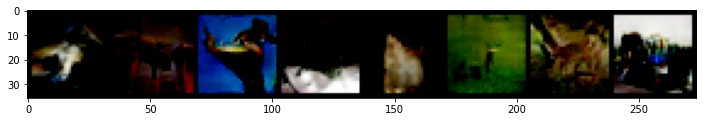

epoch: 96, batch: 100	   lossD: 0.2546(real: 0.1995, fake: 0.0551), lossG: 2.3794,  D(x): 0.8387, D(G(z)): 0.0513, 0.1613
epoch: 96, batch: 200	   lossD: 0.4749(real: 0.3930, fake: 0.0819), lossG: 2.2162,  D(x): 0.7092, D(G(z)): 0.0678, 0.1965
epoch: 96, batch: 300	   lossD: 0.2346(real: 0.0780, fake: 0.1565), lossG: 2.8331,  D(x): 0.9280, D(G(z)): 0.1321, 0.1524
epoch: 96, batch: 400	   lossD: 0.4217(real: 0.1520, fake: 0.2697), lossG: 2.6523,  D(x): 0.8737, D(G(z)): 0.1962, 0.1419
epoch: 96, batch: 500	   lossD: 0.3088(real: 0.2326, fake: 0.0762), lossG: 3.0166,  D(x): 0.8147, D(G(z)): 0.0692, 0.0999
epoch: 96, running_loss_D: 0.4181410074234009, running_loss_G: 3.075220823287964 

epoch: 97, batch: 100	   lossD: 0.1589(real: 0.0773, fake: 0.0815), lossG: 2.8377,  D(x): 0.9280, D(G(z)): 0.0744, 0.1332
epoch: 97, batch: 200	   lossD: 0.3576(real: 0.2969, fake: 0.0607), lossG: 2.8956,  D(x): 0.7662, D(G(z)): 0.0560, 0.1238
epoch: 97, batch: 300	   lossD: 0.3232(real: 0.2148, fake: 0.10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 100, batch: 500	   lossD: 0.2419(real: 0.0953, fake: 0.1466), lossG: 3.1975,  D(x): 0.9132, D(G(z)): 0.1213, 0.1027
epoch: 100, running_loss_D: 0.3799282908439636, running_loss_G: 3.0994603633880615 



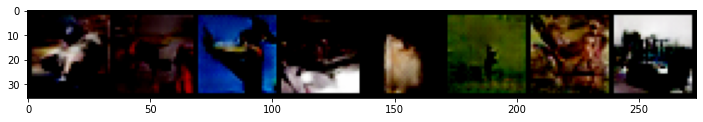

In [17]:
EPOCHS = 100 #学習の回数を変更してどれだけ綺麗になるかを出してみよう
losses, outs, nets= train(netD, netG, batch_size, zsize, EPOCHS, trainloader)

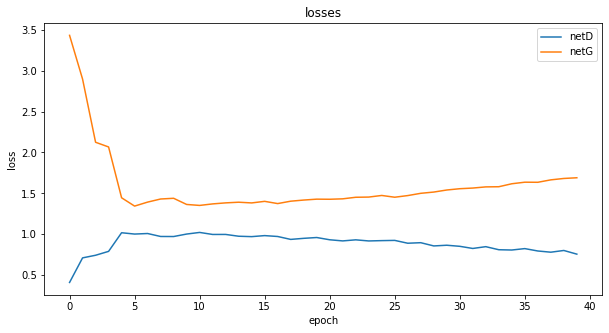

In [13]:
plt.figure(figsize=(10,5))
plt.title('losses')
plt.plot(losses[0], label='netD')
plt.plot(losses[1], label='netG')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

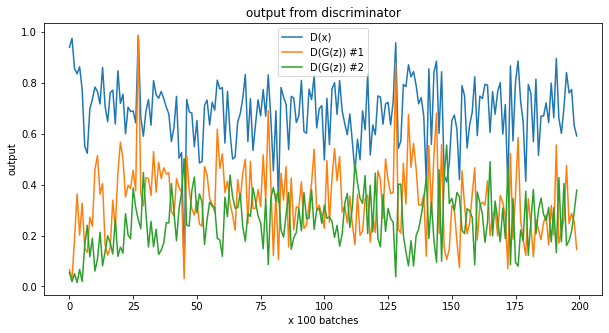

In [14]:
plt.figure(figsize=(10,5))
plt.title('output from discriminator')
plt.plot(outs[0], label='D(x)')
plt.plot(outs[1], label='D(G(z)) #1')
plt.plot(outs[2], label='D(G(z)) #2')
plt.xlabel('x 100 batches')
plt.ylabel('output')
plt.legend()
plt.show()

# 宿題




## 【1】綺麗な画像を生成して１番良さそうなのを提出してください
この事例研究の時間だけまわしておしまいなのは勿体ないです。なのでぜひ皆さんの自身の手を動かしてどのように結果が変化するのか確認しましょう！

生成した画像とlossの画像を下記のディレクトリへ金曜日までにアップロードしといてください。\
**＜提出場所＞**
```bash:
共有ドライブ/IPL Drive/05_講義資料/事例研究2020/08_20201208/課題提出箱/gxxxxxx
```
gxxxxxxには自分の学籍番号です。既に作成してあるので、そこにアップロードしてください。




## 【2】今日の話で大切だと思ったプログラムにコメントを入れる
　コメントは**ソースコードの保守をする人に情報を伝えるため**に記述します。なお、この保守する人には未来の自分も含まれます。

　いくら自分が書いたソースコードとはいえ、半年も経てば細かい仕様等は忘れていきます。なので、未来の自分や他の人がこのソースを使いたいとき、コメントがあることによって彼らの作業時間の短縮ができます。今回はその練習としてコメント入れる作業の練習をしましょう。


コメントとして記述するもの
- 実装概念との対応関係
    - 今回であれば、`GANのGeneratorはこの部分で定義されている`等
- 引数の説明
    - 特に直打ちしている値は、**その値が何なのか**がわかるようなコメントを記述しましょう

最初のセル2つは佐藤がコメントアウトで入れています。\
伝わるように書けばいいのでコメントの書き方は自由なので工夫してください。

